# Environment

In [ ]:
import matplotlib.pyplot as plt

In [1]:
import numpy as np
import copy
from gym import Env
import datetime

class FrozenLake(Env):
    def __init__(self,studentNum:int=256, nonStationary = False):
        self.studentNum = studentNum
        self.nonStationary = nonStationary
        
        np.random.seed(self.studentNum)
        self.beginMap = make_map(self.studentNum) #*2
        self.beginMap[self.beginMap>1] = 1
        self.endMap = make_map(self.studentNum + 100)
        
        self.changeDir = self.endMap - self.beginMap
        self.changeDir *= 1/11000

        self.fixedMap = self.beginMap

        np.random.seed(datetime.datetime.now().microsecond)
        
        self.map = copy.deepcopy(self.fixedMap)
        self.time = 0
        self.reset()

    def reset(self):
        self.NSreset()
        if not self.nonStationary:
            self.map = copy.deepcopy(self.fixedMap)
            self.time = 0

        return self.state

    def NSreset(self):
        self.time += 1
        self.map += self.changeDir

        self.map[self.map>0.95]=0.95
        self.map[self.map<0.0]=0.0

        self.state = (0,0)
        self.done = False
        return self.state
    
    def states_transitions(self, state, action):
        x = state[0]
        y = state[1]
        states = np.array([[x,y-1], [x,y+1], [x-1 ,y], [x+1,y] ])


        if action == UP:
            selected = states[2]
        if action == DOWN:
            selected = states[3]
        if action == RIGHT:
            selected = states[1]
        if action == LEFT:
            selected = states[0]

        zero = np.zeros((4,2)).astype(int)
        three = (3 * np.ones((4,2))).astype(int)
        output = np.maximum(np.minimum(states, three),zero)
        output, indices = np.unique(output, axis = 0, return_counts= True)

        
        selected = np.maximum(np.minimum(selected, three[0]), zero[0])
        probs = indices * 0.025
        probs[np.argmax(np.sum(selected == output, axis = 1))] += 0.9

        return list(zip(output[:,0],output[:,1])), probs
    
    def possible_consequences(self,action:int,state_now=None):

        if state_now==None:
            state_now = self.state

        state = [state_now[0],state_now[1]]
        states, probs = self.states_transitions(state, action)
        aa = np.array(states) 
        fail_probs = self.map[(aa[:,0]),(aa[:,1])]
        dones = np.sum(aa == 3, axis = 1) == 2
        return states, probs, fail_probs,dones
    
    def step(self, a:int):
        if not (a in range(4)):
            raise Exception("{} action is not available!!!".format(a))
        
        states, probs, fail_probs,dones = self.possible_consequences(a)
        
        next_idx = np.random.choice(np.arange(len(states)), p = probs)
        next_state = states[next_idx]
        self.state = tuple(next_state)
        
        self.done = dones[next_idx]

        r = -1

        if self.done:
            r += 60
        elif np.random.rand()< fail_probs[next_idx]:
            r -= 15
            self.done = True

        return (self.state, r, self.done, {})

    def render(self,state=None):
        if state == None:
            state = self.state

        out = ""
        for i in range(4):
            out += "\n------------------------------\n| "
            for j in range(4):
                if (i,j) == state:
                    out += "\033[44m{:.3f}\033[0m | ".format(self.map[i,j])
                else :
                    out += "{:.3f} | ".format(self.map[i,j])

        out += "\n------------------------------"
        print(out)

    def environment_states(self):
        env_states = []
        for state_index in range(16):
            s0 = state_index % 4
            s1 = state_index//4
            env_states.append((s0,s1))
        return env_states

        
def set_max_min(var,maximum,minimum):
    return min(max(var,minimum),maximum)

def make_map(studentNum):
    np.random.seed(studentNum)  
    move = np.zeros(6)
    idx = np.random.choice(range(6),size=3,replace=False)
    move[idx] = 1

    point = [0,0]
    lowprobs = [tuple(point)]

    for m in move:
        if m:
            point[0] += 1
        else:
            point[1] += 1
        lowprobs.append(tuple(point))
    
    map = np.random.rand(4,4)
    idx = np.array(lowprobs)

    map[idx[:,0],idx[:,1]] = 0.001 
    map[0,0] = 0.0
    map[3,3] = 0.0 

    return map

## Your Student ID

In [2]:
STUDENT_NUM = 400722138

# HyperParameters

In [3]:
#%% allowed actions
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

ACTIONS = [LEFT,DOWN,RIGHT,UP]

#%% hyperparameters
EPISODES = 10000
EPSILON = 0.1
LEARNING_RATE = 0.1
DISCOUNT = 0.9

## Map of environment

In [4]:
environment = FrozenLake(studentNum=STUDENT_NUM)

print("Environment with fail probabilities :")
environment.render()


Environment with fail probabilities :

------------------------------
| 0.000 | 0.001 | 0.001 | 0.082 | 
------------------------------
| 0.526 | 0.493 | 0.001 | 0.217 | 
------------------------------
| 0.579 | 0.570 | 0.001 | 0.001 | 
------------------------------
| 0.344 | 0.356 | 0.249 | 0.000 | 
------------------------------


## <h2><font color=indigo> Agent Implementation
Implement your q-learning (off-policy TD) agent here. You need to utilize the step function provided in the Environment class to interact with frozen lake environment.

In [38]:
import sys
import itertools
import random

class Q_Learning:
    def __init__(self, id, environment, discount , learning_rate = 0.1 , epsilon = 0.1 ,episodes=10000):

        self.environment = environment
        self.discount = discount
        self.episodes = episodes
        self.learning_rate = learning_rate
        self.environment = environment
        self.epsilon = epsilon
        self.n_actions = 4


    ######## Your Code Here ########
    def learn(self):
        G = []
        for episode in range(self.episodes):
            s = self.environment.reset()
            G_episode=0
            done=False
            episode_length=0
            
            while episode_length <=100:##  episode must be finished in 100 steps
                if random.random() < self.epsilon:## choose action epslone greedy
                    a = random.randrange(0,4)## pick a random action
                else:
                    a = np.argmax(self.environment.map[s[0],:])##choose an action
                    
                s_next,r,done,_=self.environment.step(a)
                
                ## update Q
                self.environment.map[s,a]=self.environment.map[s,a]+self.learning_rate*( r + self.discount*np.max(self.environment.map[s_next,:])-self.environment.map[s,a])
                
                G_episode+=r
                
                s = s_next
                
                episode_length += 1
                
                
                
                if done == True:
                    break
            
            G.append(G_episode)
        
        self.environment.render()
        print(sum(G)/self.episodes) 
        plt.plot(np.cumsum(Q)/np.arange(1,self.episodes+1),'.')
        return G, self.environment.map
        

## <h2><font color=indigo> Q Values
Return the Q values that your agent learns in here:


------------------------------
| 0.000 | -7.763 | 0.001 | -0.223 | 
------------------------------
| 0.526 | -7.517 | 0.001 | 0.217 | 
------------------------------
| 0.579 | 0.570 | 0.001 | 0.001 | 
------------------------------
| 0.344 | 0.356 | 0.249 | 0.000 | 
------------------------------
-17.1543


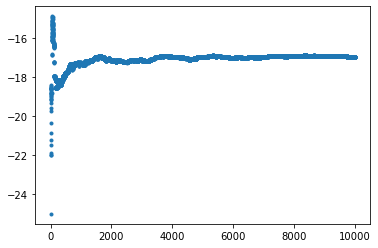

In [39]:
agent = Q_Learning('Poorya Mohammadi', environment, 0.9 , learning_rate = 0.5 , epsilon = 0.1 ,episodes= 10000)
Q , policy = agent.learn()

## <h2><font color=darkcyan> Policy
Return the optimal policy that your agent learns in here:

In [40]:
policy

array([[ 0.00000000e+00, -7.76300268e+00,  1.00000000e-03,
        -2.22736851e-01],
       [ 5.25549606e-01, -7.51676651e+00,  1.00000000e-03,
         2.17184859e-01],
       [ 5.78585102e-01,  5.69779445e-01,  1.00000000e-03,
         1.00000000e-03],
       [ 3.43598863e-01,  3.56233756e-01,  2.49387570e-01,
         0.00000000e+00]])